In [23]:
import os
from types import SimpleNamespace
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

args = SimpleNamespace(
    data_dir="data",
    model_dir="models/finetuned-code-model",
    results_dir="results",
    language="python",
    num_examples=5000,
    base_model="Salesforce/codegen-350M-mono",
    epochs=1,
    batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    eval_samples=10,
    mode="all"
)

print("✅ Arguments loaded successfully!")

✅ Arguments loaded successfully!


In [24]:
import sys

sys.path.append(os.getcwd())

In [25]:
from data.prepare_dataset import prepare_codeparrot_dataset, prepare_human_eval_dataset
from models.finetune_model import finetune_model
from models.custom_model import CustomModelAPI
from models.copilot_api import CopilotAPI, CopilotCLI
from evaluation.evaluator import CodeEvaluator
from evaluation.visualize import ResultsVisualizer

In [26]:
def prepare_data(args):
    print("\n=== 📚 Preparing datasets ===")
    prepare_codeparrot_dataset(
        num_examples=args.num_examples,
        output_dir=args.data_dir
    )
    prepare_human_eval_dataset(
        output_dir=args.data_dir
    )
    print("✅ Data preparation complete!\n")

def train_model(args):
    print("\n=== 🛠 Fine-tuning model ===")
    finetune_model(
        base_model_name=args.base_model,
        data_path=os.path.join(args.data_dir, f"{args.language}_dataset.json"),
        output_dir=args.model_dir,
        epochs=args.epochs,
        batch_size=args.batch_size,
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        learning_rate=args.learning_rate
    )
    print("✅ Model training complete!\n")

def evaluate_models(args):
    print("\n=== 🎯 Evaluating models ===")
    custom_model = CustomModelAPI(model_path=args.model_dir)

    if os.getenv("GITHUB_COPILOT_API_KEY"):
        copilot_model = CopilotAPI()
    else:
        print("⚠️ Copilot API Key missing. Falling back to CLI.")
        copilot_model = CopilotCLI()

    evaluator = CodeEvaluator(
        custom_model=custom_model,
        copilot_model=copilot_model,
        output_dir=args.results_dir
    )

    detailed_results, summary_results = evaluator.evaluate_models(
        test_dataset_path=os.path.join(args.data_dir, "human_eval_dataset.json"),
        num_samples=args.eval_samples
    )

    print("\n✅ Model evaluation complete!\n")
    return detailed_results, summary_results

def visualize_results(args):
    print("\n=== 📊 Visualizing results ===")
    visualizer = ResultsVisualizer(results_dir=args.results_dir)
    visualizer.generate_all_visualizations()
    print("✅ Visualization complete!\n")


=== 📚 Preparing datasets ===
Loading 5000 code examples from codeparrot...
Saved 5000 examples to data\python_dataset.json
Loading HumanEval dataset...
Saved 164 HumanEval examples to data\human_eval_dataset.json
✅ Data preparation complete!


=== 🛠 Fine-tuning model ===
Loading base model: Salesforce/codegen-350M-mono
Loading model without quantization...


Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

Available modules: ['transformer.h.0.attn.qkv_proj', 'transformer.h.0.attn.out_proj', 'transformer.h.1.attn.qkv_proj', 'transformer.h.1.attn.out_proj', 'transformer.h.2.attn.qkv_proj', 'transformer.h.2.attn.out_proj', 'transformer.h.3.attn.qkv_proj', 'transformer.h.3.attn.out_proj', 'transformer.h.4.attn.qkv_proj', 'transformer.h.4.attn.out_proj', 'transformer.h.5.attn.qkv_proj', 'transformer.h.5.attn.out_proj', 'transformer.h.6.attn.qkv_proj', 'transformer.h.6.attn.out_proj', 'transformer.h.7.attn.qkv_proj', 'transformer.h.7.attn.out_proj', 'transformer.h.8.attn.qkv_proj', 'transformer.h.8.attn.out_proj', 'transformer.h.9.attn.qkv_proj', 'transformer.h.9.attn.out_proj', 'transformer.h.10.attn.qkv_proj', 'transformer.h.10.attn.out_proj', 'transformer.h.11.attn.qkv_proj', 'transformer.h.11.attn.out_proj', 'transformer.h.12.attn.qkv_proj', 'transformer.h.12.attn.out_proj', 'transformer.h.13.attn.qkv_proj', 'transformer.h.13.attn.out_proj', 'transformer.h.14.attn.qkv_proj', 'transformer.h

Map: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 475.48 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting fine-tuning...


Step,Training Loss
10,0.886300
20,0.849900
30,0.902000
40,0.910300
50,0.958800
60,0.903200
70,0.925000
80,0.992000
90,0.909300
100,0.866300


Saving model to models/finetuned-code-model
✅ Model training complete!


=== 🎯 Evaluating models ===
Loading model from models/finetuned-code-model...
Using device: cuda


Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

⚠️ Copilot API Key missing. Falling back to CLI.
Evaluating sample 1/10
Error generating code with custom model: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)
Error using Copilot CLI: [WinError 2] The system cannot find the file specified
Error generating code with custom model: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)
Error using Copilot CLI: [WinError 2] The system cannot find the file specified
Evaluating sample 2/10
Error generating code with custom model: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)
Error using Copilot CLI: [WinError 2] The system cannot find the file specified
Error generati

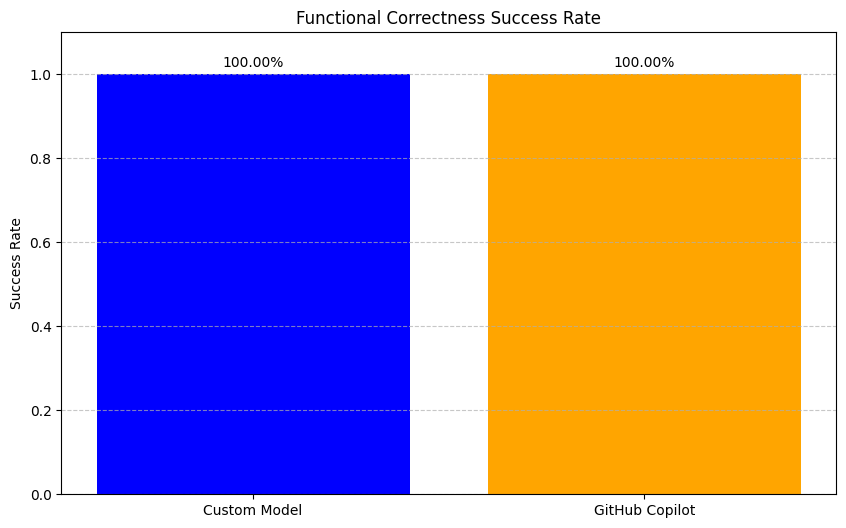

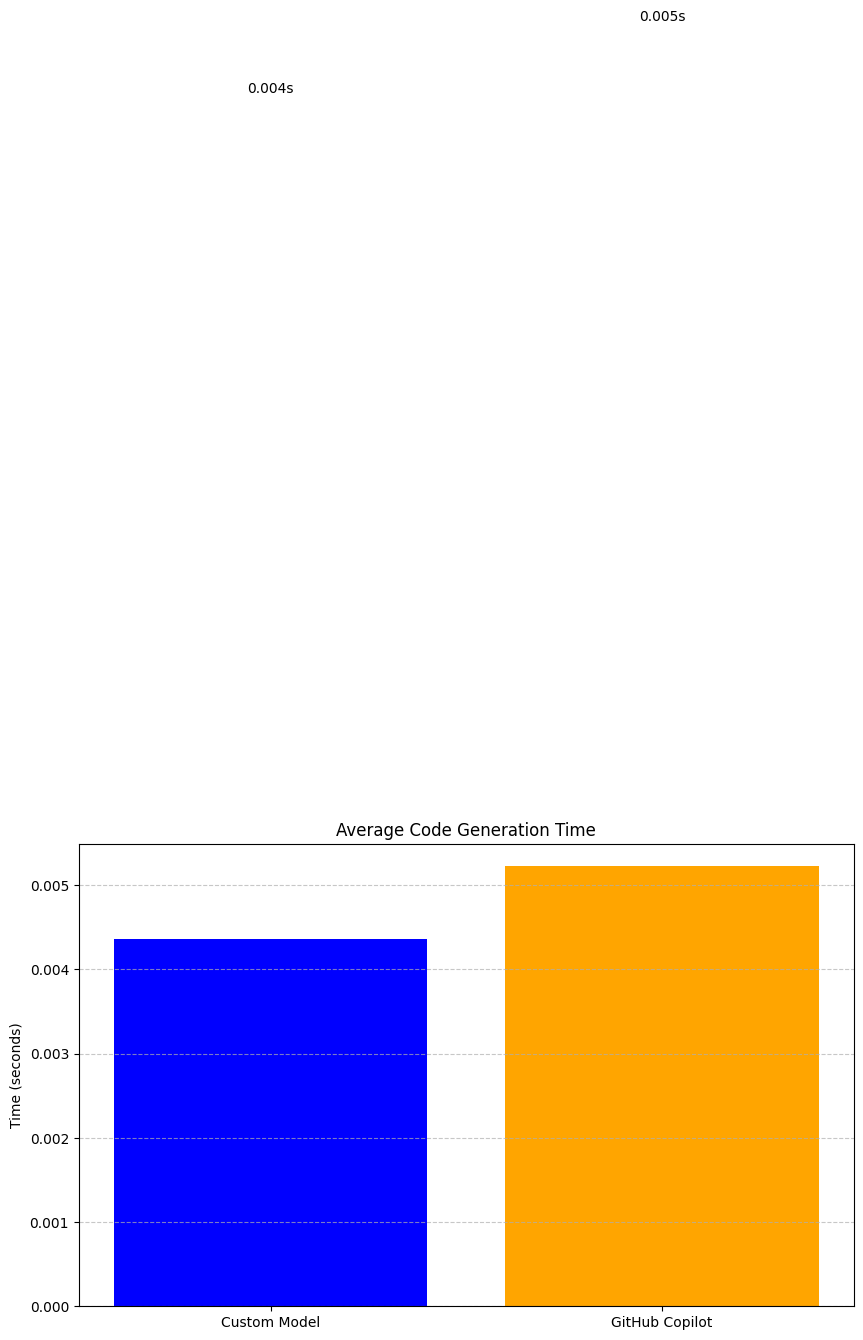

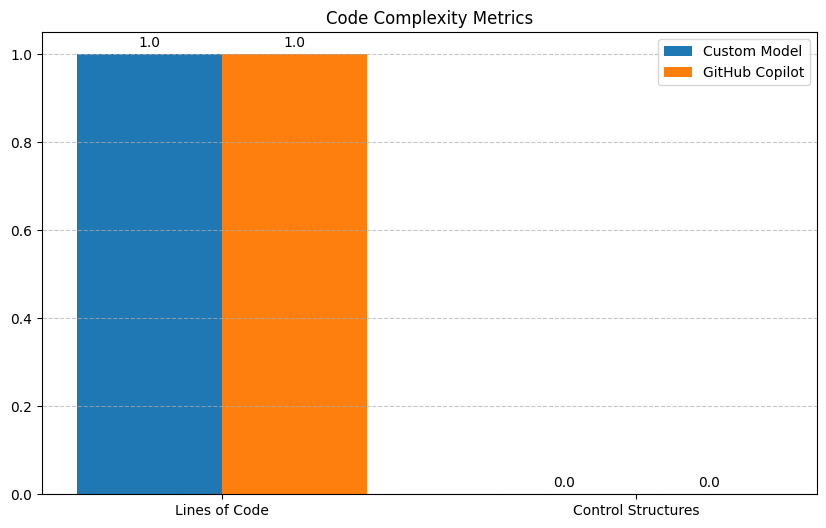

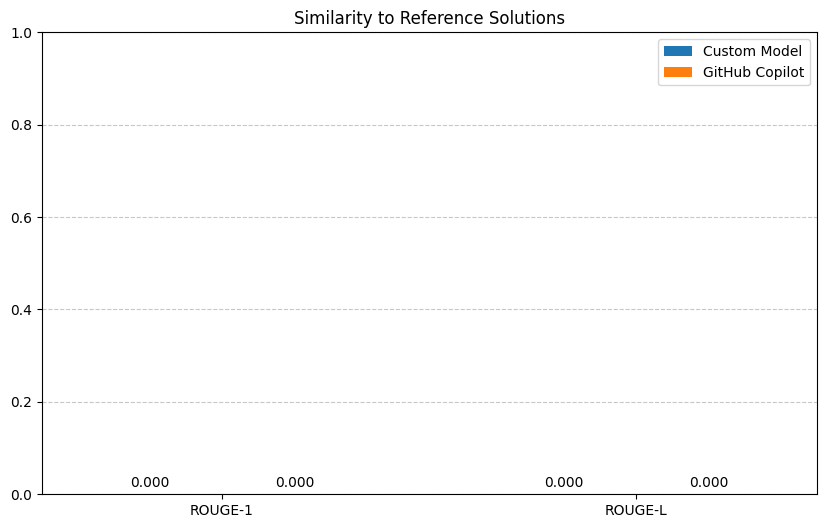

In [27]:
# Main controller

if args.mode in ["all", "data"]:
    prepare_data(args)

if args.mode in ["all", "train"]:
    train_model(args)

if args.mode in ["all", "evaluate"]:
    detailed_results, summary_results = evaluate_models(args)

if args.mode in ["all", "visualize"]:
    visualize_results(args)

print("\n🎉 ALL STAGES COMPLETED SUCCESSFULLY! 🎉")